## Importing Libraries and Dataset

In [ ]:
!pip install --quiet cython

!pip install --quiet numpy==1.24.3 scipy==1.10.1

!pip install --no-binary gensim gensim nltk

import os
os.kill(os.getpid(), 9)

In [ ]:
import ast
from collections import OrderedDict
import csv
import itertools
import multiprocessing
import random
import sys

from google.colab import drive
import gensim.downloader as api
from gensim import corpora
from gensim.corpora import Dictionary
from gensim.models import CoherenceModel, LdaModel, LdaMulticore
from gensim.models.phrases import Phrases, Phraser
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
import numpy as np
import pandas as pd
import spacy
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import TfidfModel

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
csv.field_size_limit(sys.maxsize)

9223372036854775807

In [ ]:
drive.mount('/content/drive')

df = pd.read_csv('/content/drive/MyDrive/NLP_Project/data.csv',sep='§')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-5-2312287480>:3: ParserWarning: Falling back to the 'python' engine because the separator encoded in utf-8 is > 1 char long, and the 'c' engine does not support such separators; you can avoid this warning by specifying engine='python'.
  df = pd.read_csv('/content/drive/MyDrive/NLP_Project/data.csv',sep='§')


## Text Preprocessing and BoW Corpus Construction

In [ ]:
def to_list(x):
    if isinstance(x, list):
        return x
    if isinstance(x, str):
        return ast.literal_eval(x)
    return []

In [ ]:
df = df.dropna(subset=["tokens_lemmatized"])

df["tokens_lemmatized"] = df["tokens_lemmatized"].apply(to_list)

df = df[df["tokens_lemmatized"].apply(bool)]

In [ ]:
extra_stops = {"hi","hello","please", 'regard',"enron", "enrononline", 'time', 'week', 'thank', 'today','fyi','great', 'good'}
stops = set(stopwords.words("english")) | extra_stops

In [ ]:
nlp = spacy.load("en_core_web_sm", disable=["parser","ner","textcat"])

In [ ]:
# Process each document through spaCy then keep only alphabetic, non-stopword lemmas longer than 2 characters and of POS type NOUN, PROPN, or ADJ

texts_filtered = []
for doc in nlp.pipe(
    [" ".join(toks) for toks in df["tokens_lemmatized"]],
    batch_size=2000,
    n_process=4
):
    filtered = [
        tok.lemma_.lower()
        for tok in doc
        if (
            tok.is_alpha
            and tok.lemma_.lower() not in stops
            and len(tok.lemma_) > 2
            and tok.pos_ in ("NOUN","PROPN","ADJ")
        )
    ]
    texts_filtered.append(filtered)

In [ ]:
df = df.reset_index(drop=True)

# detect common two-word phrases
bigram = Phrases(texts_filtered, min_count=5, threshold=25)

# detect common three-word phrases built from our bigrams
trigram = Phrases(bigram[texts_filtered], threshold=25)

bigram_mod = Phraser(bigram)
trigram_mod = Phraser(trigram)

texts_ngrams = [
    trigram_mod[ bigram_mod[doc] ]
    for doc in texts_filtered
]

In [ ]:
MAX_TOKEN_LEN   = 30
MAX_UNDERSCORES = 2

def prune_ngrams(doc):
    pruned = []
    for t in doc:
        if len(t) > MAX_TOKEN_LEN:
            continue
        if t.count("_") > MAX_UNDERSCORES:
            continue
        pruned.append(t)
    return pruned

bigram_mod = Phraser(bigram)
trigram_mod = Phraser(trigram)

texts_ngrams = [
    prune_ngrams( trigram_mod[ bigram_mod[doc] ] )
    for doc in texts_filtered
]

In [ ]:
# Build and filter dictionary
id2word = corpora.Dictionary(texts_ngrams)
id2word.filter_extremes(no_below=15, no_above=0.2, keep_n=100000)
print(f"Vocabolario globale: {len(id2word)} termini")

# Create BoW corpus
corpus = [id2word.doc2bow(doc) for doc in texts_ngrams]

Vocabolario globale: 18026 termini


## Grid Search

In [ ]:
# hyperparameter and topic grid
ks     = [4, 5, 6, 7, 8]
alphas = ["symmetric", "asymmetric"]
etas   = ["symmetric", "auto"]

results = []

for level in df["Level"].unique():
    idxs     = df.index[df["Level"] == level].tolist()
    texts_lvl = [texts_ngrams[i] for i in idxs]
    corpus_lvl = [id2word.doc2bow(doc) for doc in texts_lvl]

    for k, alpha, eta in itertools.product(ks, alphas, etas):

        lda_tune = LdaMulticore(
        corpus=corpus_lvl,
        id2word=id2word,
        num_topics=k,
        alpha=alpha,
        eta=eta,
        passes=10,
        chunksize=5000,
        workers=max(1, multiprocessing.cpu_count()-1),
        random_state=42
    )
        # compute coherence
        coherence = CoherenceModel(
            model=lda_tune,
            texts=texts_lvl,
            dictionary=id2word,
            coherence="c_v"
        ).get_coherence()

        results.append({
            "level":    level,
            "k":        k,
            "alpha":    alpha,
            "eta":      eta,
            "coherence": coherence
        })
        print(f"Level={level} | k={k}, alpha={alpha}, eta={eta} -> coherence={coherence:.4f}")


grid_df = pd.DataFrame(results)


best_params = {}
for level, group in grid_df.groupby("level"):
    best = group.sort_values("coherence", ascending=False).iloc[0]
    best_params[level] = {
        "k":     best["k"],
        "alpha": best["alpha"],
        "eta":   best["eta"]
    }
print("\nBest hyperparameters per level:")
print(best_params)

Level=High | k=4, alpha=symmetric, eta=symmetric -> coherence=0.5260
Level=High | k=4, alpha=symmetric, eta=auto -> coherence=0.5035
Level=High | k=4, alpha=asymmetric, eta=symmetric -> coherence=0.5595
Level=High | k=4, alpha=asymmetric, eta=auto -> coherence=0.5313
Level=High | k=5, alpha=symmetric, eta=symmetric -> coherence=0.5073
Level=High | k=5, alpha=symmetric, eta=auto -> coherence=0.5011
Level=High | k=5, alpha=asymmetric, eta=symmetric -> coherence=0.5345
Level=High | k=5, alpha=asymmetric, eta=auto -> coherence=0.5345
Level=High | k=6, alpha=symmetric, eta=symmetric -> coherence=0.5103
Level=High | k=6, alpha=symmetric, eta=auto -> coherence=0.5103
Level=High | k=6, alpha=asymmetric, eta=symmetric -> coherence=0.5253
Level=High | k=6, alpha=asymmetric, eta=auto -> coherence=0.5338
Level=High | k=7, alpha=symmetric, eta=symmetric -> coherence=0.4753
Level=High | k=7, alpha=symmetric, eta=auto -> coherence=0.4731
Level=High | k=7, alpha=asymmetric, eta=symmetric -> coherence=

Level=Low | k=4, alpha=symmetric, eta=auto -> coherence=0.4281
Level=Low | k=4, alpha=asymmetric, eta=symmetric -> coherence=0.3782


Level=Low | k=4, alpha=asymmetric, eta=auto -> coherence=0.3759
Level=Low | k=5, alpha=symmetric, eta=symmetric -> coherence=0.4017


Level=Low | k=5, alpha=symmetric, eta=auto -> coherence=0.4108
Level=Low | k=5, alpha=asymmetric, eta=symmetric -> coherence=0.3813


Level=Low | k=5, alpha=asymmetric, eta=auto -> coherence=0.3921
Level=Low | k=6, alpha=symmetric, eta=symmetric -> coherence=0.3866
Level=Low | k=6, alpha=symmetric, eta=auto -> coherence=0.3744
Level=Low | k=6, alpha=asymmetric, eta=symmetric -> coherence=0.4139
Level=Low | k=6, alpha=asymmetric, eta=auto -> coherence=0.4107
Level=Low | k=7, alpha=symmetric, eta=symmetric -> coherence=0.3586
Level=Low | k=7, alpha=symmetric, eta=auto -> coherence=0.3528
Level=Low | k=7, alpha=asymmetric, eta=symmetric -> coherence=0.4356
Level=Low | k=7, alpha=asymmetric, eta=auto -> coherence=0.4124
Level=Low | k=8, alpha=symmetric, eta=symmetric -> coherence=0.3716
Level=Low | k=8, alpha=symmetric, eta=auto -> coherence=0.3659
Level=Low | k=8, alpha=asymmetric, eta=symmetric -> coherence=0.3411
Level=Low | k=8, alpha=asymmetric, eta=auto -> coherence=0.3540
Level=Medium | k=4, alpha=symmetric, eta=symmetric -> coherence=0.4418


Level=Medium | k=4, alpha=symmetric, eta=auto -> coherence=0.4445
Level=Medium | k=4, alpha=asymmetric, eta=symmetric -> coherence=0.4707


Level=Medium | k=4, alpha=asymmetric, eta=auto -> coherence=0.4772
Level=Medium | k=5, alpha=symmetric, eta=symmetric -> coherence=0.4631
Level=Medium | k=5, alpha=symmetric, eta=auto -> coherence=0.4578
Level=Medium | k=5, alpha=asymmetric, eta=symmetric -> coherence=0.4967
Level=Medium | k=5, alpha=asymmetric, eta=auto -> coherence=0.4967
Level=Medium | k=6, alpha=symmetric, eta=symmetric -> coherence=0.4423
Level=Medium | k=6, alpha=symmetric, eta=auto -> coherence=0.4423
Level=Medium | k=6, alpha=asymmetric, eta=symmetric -> coherence=0.4831
Level=Medium | k=6, alpha=asymmetric, eta=auto -> coherence=0.4803
Level=Medium | k=7, alpha=symmetric, eta=symmetric -> coherence=0.4332
Level=Medium | k=7, alpha=symmetric, eta=auto -> coherence=0.4687
Level=Medium | k=7, alpha=asymmetric, eta=symmetric -> coherence=0.4663
Level=Medium | k=7, alpha=asymmetric, eta=auto -> coherence=0.4755
Level=Medium | k=8, alpha=symmetric, eta=symmetric -> coherence=0.4518
Level=Medium | k=8, alpha=symmetri

## LDA Topic Modeling with Optimized Hyperparameters

In [ ]:
# best hyperparameters from the grid search
best_params = {
    "High": {"k": 4, "alpha": "asymmetric", "eta": "symmetric"},
    "Medium": {"k": 5, "alpha": "asymmetric",  "eta": "symmetric"},
    "Low": {"k": 7, "alpha": "asymmetric",  "eta": "symmetric"},
}

level_models = OrderedDict()
print("\n Topics per Level")

for level in df["Level"].unique():
    params    = best_params.get(level, {"k": 4, "alpha": 1.0/4, "eta": 1.0/4})
    num_topics = params["k"]
    alpha      = params["alpha"]
    eta        = params["eta"]

    # Gather the BoW vectors for the level
    idxs      = df.index[df["Level"] == level].tolist()
    corpus_sub = [corpus[i] for i in idxs]

    # Train using the level parameters
    lda_lvl = LdaMulticore(
        corpus=corpus_sub,
        id2word=id2word,
        num_topics=num_topics,
        alpha=alpha,
        eta=eta,
        passes=20,
        chunksize=5000,
        workers=max(1, multiprocessing.cpu_count() - 1),
        random_state=42
    )
    level_models[level] = lda_lvl

    print(f"\n→ Level = {level} (n_docs = {len(idxs)})")
    for idx, topic in lda_lvl.print_topics(num_words=6):
        print(f"  Topic {idx:02d}: {topic}")


 Topics per Level

→ Level = High (n_docs = 36246)
  Topic 00: 0.012*"meeting" + 0.012*"work" + 0.010*"vince" + 0.008*"day" + 0.008*"office" + 0.008*"talk"
  Topic 01: 0.012*"delainey" + 0.011*"work" + 0.009*"deal" + 0.008*"people" + 0.007*"number" + 0.007*"contract"
  Topic 02: 0.012*"business" + 0.011*"information" + 0.010*"team" + 0.010*"list" + 0.010*"operation" + 0.008*"report"
  Topic 03: 0.018*"business" + 0.018*"market" + 0.012*"price" + 0.011*"power" + 0.009*"group" + 0.008*"new"

→ Level = Low (n_docs = 111809)
  Topic 00: 0.035*"schedule" + 0.012*"transtype_final" + 0.011*"work" + 0.010*"message_parse" + 0.010*"email" + 0.009*"day"
  Topic 01: 0.034*"deal" + 0.018*"change" + 0.018*"agreement" + 0.010*"list" + 0.009*"question" + 0.009*"trade"
  Topic 02: 0.019*"company" + 0.011*"share" + 0.010*"transaction" + 0.010*"business" + 0.010*"partnership" + 0.009*"stock"
  Topic 03: 0.013*"gas" + 0.013*"market" + 0.012*"ferc" + 0.012*"capacity" + 0.010*"project" + 0.010*"service"
  

In [ ]:
custom_labels = {
    "High": {
        0: "Executive Meetings & Communications",
        1: "Contract Negotiations & Team Coordination",
        2: "Business & Team Operations",
        3: "Market Pricing & Energy Trading",
    },
    "Medium": {
        0: "Daily Team Coordination",
        1: "Transaction Processing & Credit Documentation",
        2: "Corporate Trading & Financial Operations",
        3: "Gas Trading & Market Deals",
        4: "California Power Market & Utility Operations",
    },
    "Low": {
        0: "Schedule & Workflow Automation",
        1: "Deal Management & Change Requests",
        2: "Corporate Transactions",
        3: "Regulatory Oversight & Energy Transmission",
        4: "System Operations & Database Errors",
        5: "California Energy Market & Electricity Pricing",
        6: "Energy Company Stocks & Market Performance"
    }
}

In [ ]:
texts_by_level = {
    lvl: [texts_ngrams[i] for i in df.index[df["Level"] == lvl]]
    for lvl in level_models
}

coherence_records = []
topn = 10
for lvl, lda in level_models.items():
    texts_lvl = texts_by_level[lvl]
    for t in range(lda.num_topics):
        terms = [w for w, _ in lda.show_topic(t, topn=topn)]
        cm = CoherenceModel(
            topics=[terms],
            texts=texts_lvl,
            dictionary=id2word,
            coherence='c_v'
        )
        coherence_records.append({
            "Level":      lvl,
            "Topic":      t,
            "Coherence":  cm.get_coherence()
        })

coherence_df = pd.DataFrame(coherence_records)

label_records = []
for lvl, lda in level_models.items():
    for t in range(lda.num_topics):

        top2 = [w for w, _ in lda.show_topic(t, topn=2)]
        label_records.append({
            "Level": lvl,
            "Topic": t,
            "Label":  " & ".join(top2)
        })

label_df = pd.DataFrame(label_records)

dominant = []
for i, row in df.iterrows():
    lvl = row["Level"]
    bow = corpus[i]
    lda = level_models[lvl]
    top_tid, top_p = max(lda.get_document_topics(bow), key=lambda x: x[1])
    dominant.append((i, lvl, top_tid))

dominant_df = (
    pd.DataFrame(dominant, columns=["doc_id","Level","Topic"])
      .groupby(["Level","Topic"])
      .size()
      .reset_index(name="Count")
)

result = (
    coherence_df
      .merge(label_df,     on=["Level","Topic"])
      .merge(dominant_df,  on=["Level","Topic"], how="left")
      .fillna(0)
      .sort_values(["Level","Coherence"], ascending=[True, False])
      .reset_index(drop=True)
)

result["CustomLabel"] = result.apply(
    lambda r: custom_labels[r["Level"]][r["Topic"]],
    axis=1
)

In [ ]:
print(result[["Level","CustomLabel","Coherence"]])

     Level                                     CustomLabel  Coherence
0     High                      Business & Team Operations   0.685616
1     High                 Market Pricing & Energy Trading   0.667013
2     High       Contract Negotiations & Team Coordination   0.512692
3     High             Executive Meetings & Communications   0.492787
4      Low                      Collaborative Transactions   0.606136
5      Low  California Energy Market & Electricity Pricing   0.524227
6      Low      Energy Company Stocks & Market Performance   0.473641
7      Low               Deal Management & Change Requests   0.393900
8      Low      Regulatory Oversight & Energy Transmission   0.390852
9      Low             System Operations & Database Errors   0.280668
10     Low                  Schedule & Workflow Automation   0.260465
11  Medium    California Power Market & Utility Operations   0.683192
12  Medium        Corporate Trading & Financial Operations   0.681132
13  Medium          

## Topic Similarity Using Cosine Similarity

In [ ]:
tfidf_model = TfidfModel(corpus)
corpus_tfidf = tfidf_model[corpus]

num_docs = len(corpus_tfidf)
num_terms = len(id2word)

tfidf_matrix = np.zeros((num_docs, num_terms))

for doc_id, doc in enumerate(corpus_tfidf):
    for term_id, tfidf_score in doc:
        tfidf_matrix[doc_id, term_id] = tfidf_score

In [ ]:
# Get the dominant topic for each document
dominant_topics = []
for doc_bow in corpus:
    topics = lda_lvl.get_document_topics(doc_bow)
    dominant_topic = max(topics, key=lambda x: x[1])[0]
    dominant_topics.append(dominant_topic)

In [ ]:
unique_topics = np.unique(dominant_topics)
num_topics = lda_lvl.num_topics

ctfidf_matrix = np.zeros((num_topics, num_terms))

for topic in unique_topics:
    doc_indices = [i for i, t in enumerate(dominant_topics) if t == topic]

    ctfidf_matrix[topic] = tfidf_matrix[doc_indices].mean(axis=0)

In [ ]:
feature_names = [id2word[i] for i in range(len(id2word))]

In [ ]:
def compute_cosine_coherence_ctfidf(ctfidf_matrix, feature_names, top_n=10):
    coherence_scores = {}

    for topic_idx, topic_vector in enumerate(ctfidf_matrix):
        top_word_indices = topic_vector.argsort()[::-1][:top_n]
        top_word_vectors = ctfidf_matrix[:, top_word_indices].T

        if top_word_vectors.shape[0] < 2:
            coherence_scores[topic_idx] = 0.0
            continue

        similarity_matrix = cosine_similarity(top_word_vectors)
        upper_triangle = similarity_matrix[np.triu_indices_from(similarity_matrix, k=1)]
        avg_similarity = upper_triangle.mean() if upper_triangle.size else 0.0
        coherence_scores[topic_idx] = avg_similarity

    return coherence_scores

level_coherence = {}

for level in df["Level"].unique():
    print(f"\nLevel: {level}")

    # get index and corpus for each level
    level_indices = df.index[df["Level"] == level].tolist()
    corpus_level = [corpus[i] for i in level_indices]

    tfidf_model = TfidfModel(corpus_level)
    corpus_tfidf = tfidf_model[corpus_level]

    # TF-IDF matrix construction
    num_docs_level = len(corpus_level)
    num_terms = len(id2word)
    tfidf_matrix = np.zeros((num_docs_level, num_terms))

    for doc_id, doc in enumerate(corpus_tfidf):
        for term_id, tfidf_score in doc:
            tfidf_matrix[doc_id, term_id] = tfidf_score

    # topic relevance for each levels document
    lda_model_level = level_models[level]
    dominant_topics = []
    for doc_bow in corpus_level:
        topics = lda_model_level.get_document_topics(doc_bow)
        dominant_topic = max(topics, key=lambda x: x[1])[0]
        dominant_topics.append(dominant_topic)

    # c-TF-IDF
    unique_topics = np.unique(dominant_topics)
    num_topics = lda_model_level.num_topics

    ctfidf_matrix = np.zeros((num_topics, num_terms))

    for topic in unique_topics:
        doc_indices = [i for i, t in enumerate(dominant_topics) if t == topic]
        ctfidf_matrix[topic] = tfidf_matrix[doc_indices].mean(axis=0)

    feature_names = [id2word[i] for i in range(len(id2word))]

    coherence_scores = compute_cosine_coherence_ctfidf(ctfidf_matrix, feature_names, top_n=10)

    level_coherence[level] = coherence_scores

    # results
    for topic_id, score in coherence_scores.items():
        print(f"Topic {topic_id}: Cosine Coherence = {score:.4f}")


Level: High
Topic 0: Cosine Coherence = 0.8248
Topic 1: Cosine Coherence = 0.9006
Topic 2: Cosine Coherence = 0.8606
Topic 3: Cosine Coherence = 0.9541

Level: Low
Topic 0: Cosine Coherence = 0.8010
Topic 1: Cosine Coherence = 0.8808
Topic 2: Cosine Coherence = 0.7651
Topic 3: Cosine Coherence = 0.8434
Topic 4: Cosine Coherence = 0.8798
Topic 5: Cosine Coherence = 0.8729
Topic 6: Cosine Coherence = 0.8458

Level: Medium
Topic 0: Cosine Coherence = 0.8668
Topic 1: Cosine Coherence = 0.9591
Topic 2: Cosine Coherence = 0.8976
Topic 3: Cosine Coherence = 0.8528
Topic 4: Cosine Coherence = 0.9465


## Topic Distribution Through Time

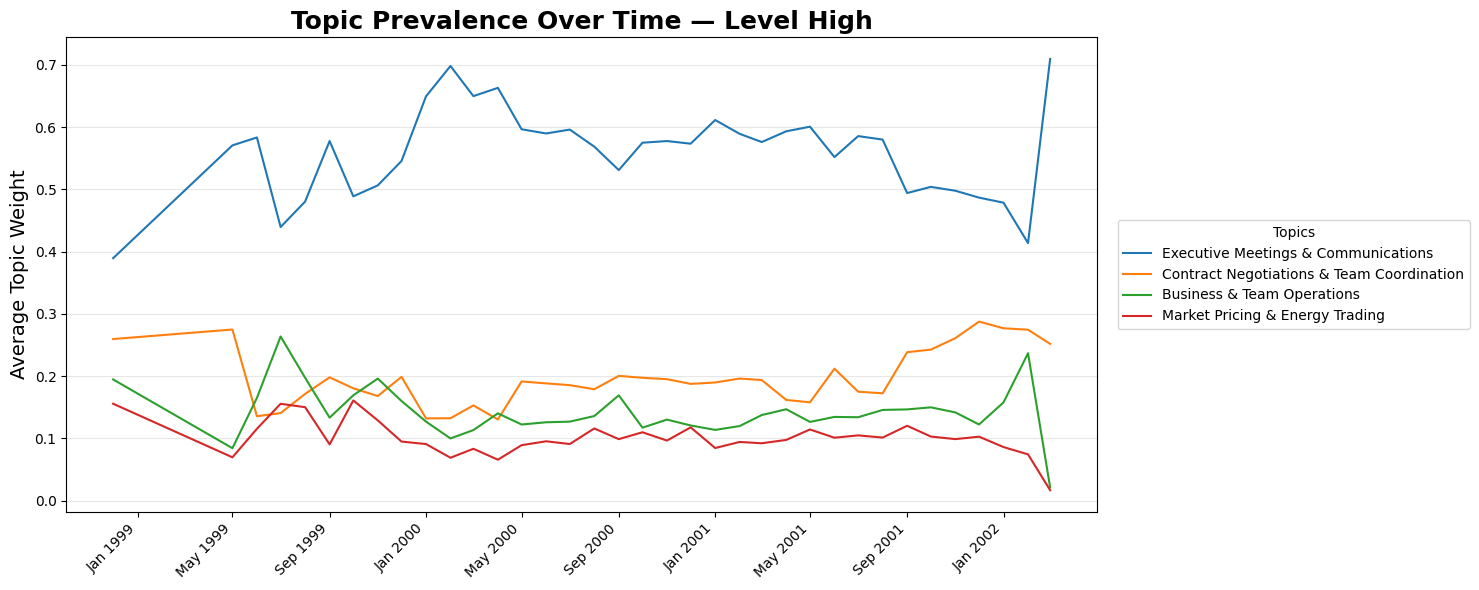

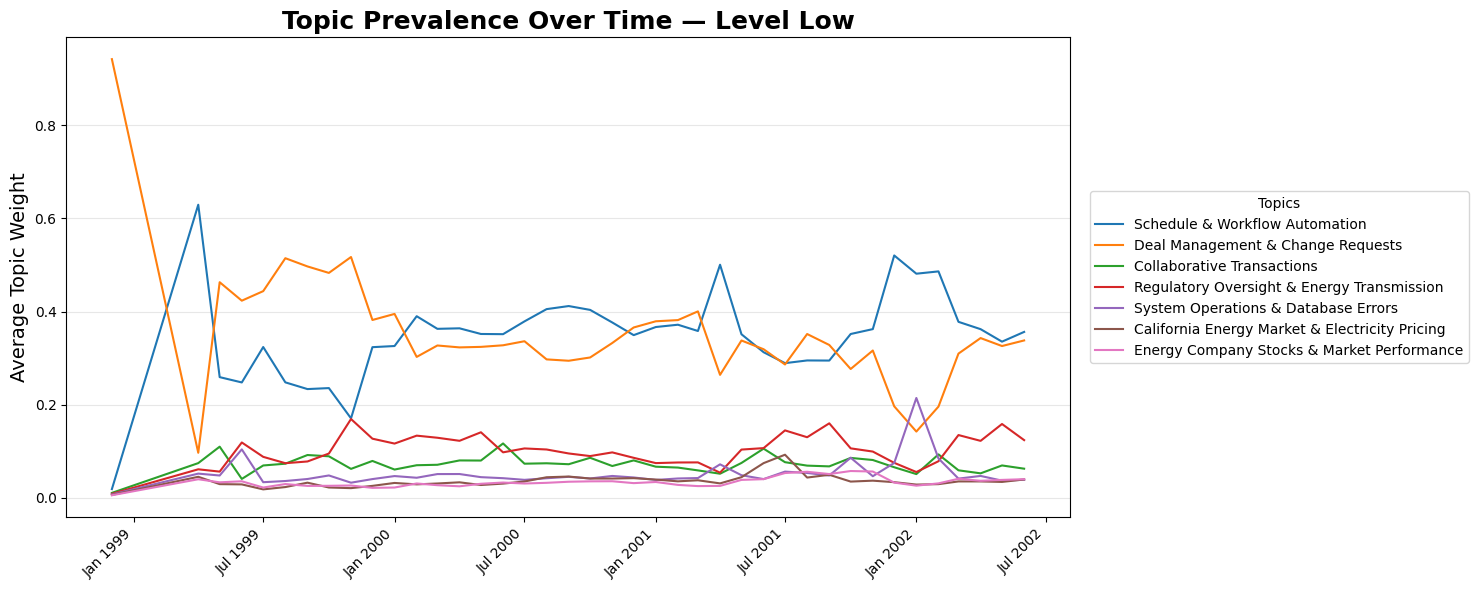

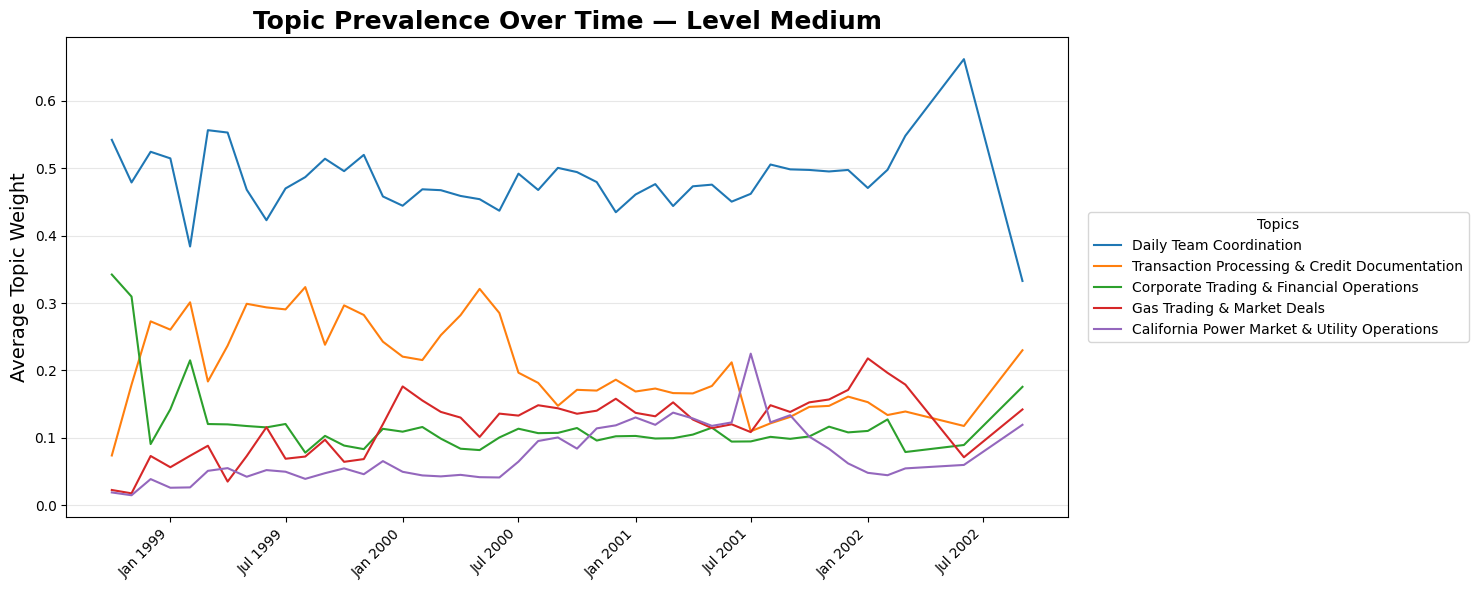

In [ ]:
for level, lda_lvl in level_models.items():
    # filter docs by level
    mask     = df["Level"] == level
    df_lvl   = df.loc[mask].reset_index(drop=True)
    idxs     = df.index[mask].tolist()
    bows_lvl = [corpus[i] for i in idxs]

    # infer topic weights
    td = [
        dict(lda_lvl.get_document_topics(bow, minimum_probability=0))
        for bow in bows_lvl
    ]
    td_df = pd.DataFrame(td)
    td_df["year_month"] = df_lvl["year_month"]

    # aggregate by month
    agg = td_df.groupby("year_month").mean().sort_index()
    agg.index = pd.to_datetime(agg.index + "-01")

    # plot
    plt.figure(figsize=(20, 6))
    for topic_id, series in agg.items():
        label = custom_labels[level].get(topic_id, f"Topic {topic_id}")
        plt.plot(agg.index, series, label=label)

    plt.title(f"Topic Prevalence Over Time — Level {level}", fontsize=18, weight="bold")
    plt.ylabel("Average Topic Weight", fontsize=14)
    plt.grid(axis="y", alpha=0.3)

    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
    plt.xticks(rotation=45, ha="right")

    plt.legend(
        title="Topics",
        bbox_to_anchor=(1.02, 0.5),
        loc="center left",
        borderaxespad=0,
        fontsize=10
    )

    plt.tight_layout(rect=(0, 0, 0.75, 1))
    plt.show()